# Stage 3.5 Final Baseline (train_gpt_original.py, 1 seed) vs Stage 3 Results

In [1]:
%%bash
source /workspace/ese-3060-project/.venv/bin/activate
python -m ipykernel install --user --name ese3060-venv --display-name "ese3060 venv"
echo "Kernel installed."

Installed kernelspec ese3060-venv in /root/.local/share/jupyter/kernels/ese3060-venv
Kernel installed.


In [1]:
from pathlib import Path
import os, subprocess, json, glob, re
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%cd /workspace/ese-3060-project

# Detect project root: prefer PROJ_ROOT env, else repo root (parent if running from notebooks/)
cwd = Path.cwd().expanduser().resolve()
default_root = cwd.parent if cwd.name == 'notebooks' else cwd
PROJ_ROOT = Path(os.environ.get('PROJ_ROOT', default_root)).expanduser().resolve()
SCRIPT_PATH = PROJ_ROOT / 'train_gpt_original.py'
RESULTS_ALL = PROJ_ROOT / 'experiments' / 'results.csv'
RESULTS_STAGE3 = PROJ_ROOT / 'experiments' / 'results_stage3.csv'
RESULTS_STAGE3_ALT = PROJ_ROOT / 'experiments' / 'results_stage_3.csv'
BASELINE_OUT = PROJ_ROOT / 'experiments' / 'baseline.csv'
LOG_DIR = PROJ_ROOT / 'logs'

print('Project root:', PROJ_ROOT)
print('Using script:', SCRIPT_PATH)
print('Results files checked:', RESULTS_STAGE3, RESULTS_STAGE3_ALT, RESULTS_ALL)
print('Logs:', LOG_DIR)
print('Baseline export:', BASELINE_OUT)

/workspace/ese-3060-project
Project root: /workspace/ese-3060-project
Using script: /workspace/ese-3060-project/train_gpt_original.py
Results files checked: /workspace/ese-3060-project/experiments/results_stage3.csv /workspace/ese-3060-project/experiments/results_stage_3.csv /workspace/ese-3060-project/experiments/results.csv
Logs: /workspace/ese-3060-project/logs
Baseline export: /workspace/ese-3060-project/experiments/baseline.csv


In [2]:
# Runtime knobs (one seed baseline)
NPROC = None                # auto-detect GPU count if None
SEED = 1337                # train_gpt_original.py reads SEED env
VAL_EVERY = 125            # train_gpt_original.py reads VAL_EVERY env
TORCHRUN = "torchrun"
LAUNCH = True              # set True to run

# train_gpt_original.py uses built-in defaults for lr/iters/warmdown; not adjustable here
if NPROC is None:
    try:
        gpu_count = int(subprocess.check_output("nvidia-smi --list-gpus | wc -l", shell=True).decode().strip())
    except Exception:
        gpu_count = 0
    NPROC = max(gpu_count, 1)

assert SCRIPT_PATH.exists(), f"Missing train script: {SCRIPT_PATH}"

def run_baseline(seed):
    env = os.environ.copy()
    env.update({
        "SEED": str(seed),
        "VAL_EVERY": str(VAL_EVERY),
    })
    cmd = [TORCHRUN, "--standalone", f"--nproc_per_node={NPROC}", str(SCRIPT_PATH)]
    print(f"\n>>> Launching baseline (train_gpt_original) seed={seed} nproc={NPROC}")
    if not LAUNCH:
        return 0
    proc = subprocess.run(cmd, env=env)
    if proc.returncode != 0:
        raise RuntimeError(f"Run failed: baseline seed {seed} rc={proc.returncode}")

run_baseline(SEED)
print("Done (LAUNCH=" + str(LAUNCH) + ")")



>>> Launching baseline (train_gpt_original) seed=1337 nproc=8


W1209 23:53:26.378000 1675 torch/distributed/run.py:774] 
W1209 23:53:26.378000 1675 torch/distributed/run.py:774] *****************************************
W1209 23:53:26.378000 1675 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1209 23:53:26.378000 1675 torch/distributed/run.py:774] *****************************************


using device: cuda:5
using device: cuda:4
using device: cuda:2
using device: cuda:1
using device: cuda:0
using device: cuda:6
using device: cuda:3
using device: cuda:7
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/5100 val_loss:15.9940 train_time:149ms step_avg:nanms
step:1/5100 train_loss:15.9902 train_time:81752ms step_avg:nanms
step:2/5100 train_loss:9.5516 train_time:84455ms step_avg:nanms
step:3/5100 train_loss:8.7724 train_time:84748ms step_avg:nanms
step:4/5100 train_loss:8.1357 train_time:85039ms step_avg:nanms
step:5/5100 train_loss:7.6483 train_time:85329ms step_avg:nanms
step:6/5100 train_loss:7.6047 train_time:85619ms step_avg:nanms
step:7/5100 train_loss:7.2767 train_time:85909ms step_avg:nanms
step:8/5100 train_loss:7.4519 train_time:86199ms step_avg:nanms
step:9/5100 train_loss:7.4163 train_time:86489ms step_avg:nanms
step:10/5100 train_loss:7.0496 train_time:86778ms st

In [4]:
# Parse latest baseline log and save to baseline.csv
VAL_RE = re.compile(r"step:(\d+)/(\d+) val_loss:([0-9.]+) train_time:(\d+)ms step_avg:([0-9.]+)ms")

def parse_latest_log(log_dir: Path):
    if not log_dir.exists():
        return None, None
    txts = sorted(log_dir.glob('*.txt'), key=lambda p: p.stat().st_mtime, reverse=True)
    if not txts:
        return None, None
    path = txts[0]
    rows = []
    for line in open(path):
        m = VAL_RE.search(line)
        if m:
            step = int(m.group(1)); total = int(m.group(2))
            vloss = float(m.group(3)); t_ms = int(m.group(4)); step_avg = float(m.group(5))
            rows.append((step, total, vloss, t_ms, step_avg))
    if not rows:
        return path.stem, None
    final = rows[-1]
    best = min(rows, key=lambda r: r[2])
    data = {
        'run_id': path.stem,
        'seed': SEED,
        'learning_rate': 0.0036,
        'num_iterations': final[1],
        'warmdown_iters': 1450,
        'final_val_loss': final[2],
        'best_val_loss': best[2],
        'train_time_ms': final[3],
        'ms_per_step': final[4],
        'attn_gate': 'none',
    }
    return path.stem, pd.DataFrame([data])

log_id, baseline_df = parse_latest_log(LOG_DIR)
if baseline_df is not None:
    BASELINE_OUT.parent.mkdir(parents=True, exist_ok=True)
    baseline_df.to_csv(BASELINE_OUT, index=False)
    display(baseline_df)
    print(f"Saved baseline run ({log_id}) to {BASELINE_OUT}")
else:
    print('No baseline log parsed; ensure run was launched.')

,run_id,seed,learning_rate,num_iterations,warmdown_iters,final_val_loss,best_val_loss,train_time_ms,ms_per_step,attn_gate
0,475d68c0-dc6e-4bfa-97ed-f62ebf38fca8,1337,0.0036,5100,1450,3.2938,3.2938,1476879,290.15,none


Saved baseline run (475d68c0-dc6e-4bfa-97ed-f62ebf38fca8) to /workspace/ese-3060-project/experiments/baseline.csv


In [5]:
# Load stage 3 results for comparison
if RESULTS_STAGE3.exists():
    stage3 = pd.read_csv(RESULTS_STAGE3)
elif RESULTS_STAGE3_ALT.exists():
    stage3 = pd.read_csv(RESULTS_STAGE3_ALT)
elif RESULTS_ALL.exists():
    stage3 = pd.read_csv(RESULTS_ALL)
else:
    stage3 = pd.DataFrame()

if not stage3.empty:
    # Optional filter for full-run params if needed
    pass
stage3.head() if not stage3.empty else stage3

,run_id,date,git_commit,seed,attn_gate,gate_pos,gate_act,learning_rate,batch_size,device_batch_size,...,num_iterations,warmdown_iters,final_val_loss,best_val_loss,train_time_ms,ms_per_step,gpu_name,n_gpus,runpod_instance,notes
0,cadd9fa4-5d2f-4de3-845e-60fed27b6c1e,2025-12-09 20:28:49,08372c9882847a472c8ebf0e9b5c6c36533ad198,1337,none,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.291986,3.291986,1.476861e+06,290.092610,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN
1,bf82d241-6aa4-4dc7-871f-02a6987de4b7,2025-12-09 20:56:34,08372c9882847a472c8ebf0e9b5c6c36533ad198,2337,none,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.293929,3.293929,1.476246e+06,289.971637,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN
2,ea0310de-8c31-49bd-bcfd-49c15bde32fa,2025-12-09 21:24:18,08372c9882847a472c8ebf0e9b5c6c36533ad198,3337,none,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.292181,3.292181,1.477536e+06,290.225053,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN
3,4078749c-292d-4965-bd87-3bbf56576c8c,2025-12-09 21:54:44,08372c9882847a472c8ebf0e9b5c6c36533ad198,1337,elementwise,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.271069,3.271069,1.570615e+06,308.508160,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN
4,51c387ed-2da5-456a-b468-2cb1a66d02d8,2025-12-09 22:24:14,08372c9882847a472c8ebf0e9b5c6c36533ad198,2337,elementwise,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.272427,3.272427,1.570852e+06,308.554717,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN


,attn_gate,learning_rate,best_val_loss,final_val_loss,ms_per_step,train_time_ms,run_id,seed
0,none,0.00360,3.293800,3.293800,290.150000,1.476879e+06,475d68c0-dc6e-4bfa-97ed-f62ebf38fca8,1337
1,none,0.00468,3.291986,3.291986,290.092610,1.476861e+06,cadd9fa4-5d2f-4de3-845e-60fed27b6c1e,1337
2,none,0.00468,3.293929,3.293929,289.971637,1.476246e+06,bf82d241-6aa4-4dc7-871f-02a6987de4b7,2337
3,none,0.00468,3.292181,3.292181,290.225053,1.477536e+06,ea0310de-8c31-49bd-bcfd-49c15bde32fa,3337
4,elementwise,0.00468,3.271069,3.271069,308.508160,1.570615e+06,4078749c-292d-4965-bd87-3bbf56576c8c,1337
5,elementwise,0.00468,3.272427,3.272427,308.554717,1.570852e+06,51c387ed-2da5-456a-b468-2cb1a66d02d8,2337
6,elementwise,0.00468,3.273315,3.273315,308.644664,1.571310e+06,a3be77f5-9681-414b-af4e-e3d85509e59b,3337


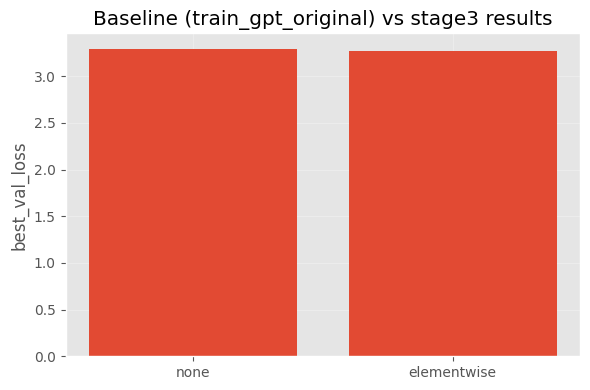

In [6]:
# Compare baseline (parsed) vs stage3 elementwise/baseline rows
if baseline_df is not None and not baseline_df.empty:
    # align columns of interest
    cols = ['attn_gate','learning_rate','best_val_loss','final_val_loss','ms_per_step','train_time_ms','run_id','seed']
    comp_list = [baseline_df[cols]]
    if not stage3.empty:
        stage_subset = stage3.copy()
        missing = [c for c in cols if c not in stage_subset.columns]
        for c in missing:
            stage_subset[c] = pd.NA
        comp_list.append(stage_subset[cols])
    comp = pd.concat(comp_list, ignore_index=True)
    display(comp)
    # Simple bar for best_val_loss
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(comp['attn_gate'], comp['best_val_loss'])
    ax.set_ylabel('best_val_loss')
    ax.set_title('Baseline (train_gpt_original) vs stage3 results')
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
else:
    print('No baseline_df to compare.')

In [8]:
# Parse logs into curves for interpolation
VAL_RE = re.compile(r"step:(\d+)/(\d+).*val_loss:([0-9.]+).*train_time:(\d+)ms")
curves = pd.DataFrame()
allowed = set()
if 'stage3' in locals() and not stage3.empty:
    allowed.update(stage3.get('run_id', []))
if 'baseline_df' in locals() and baseline_df is not None and not baseline_df.empty:
    allowed.update(baseline_df.get('run_id', []))
rows = []
if LOG_DIR.exists():
    for path in LOG_DIR.glob('*.txt'):
        rid = path.stem
        if allowed and rid not in allowed:
            continue
        cfg_row = None
        if 'stage3' in locals() and not stage3.empty:
            match_rows = stage3[stage3['run_id']==rid]
            if not match_rows.empty:
                cfg_row = match_rows.iloc[0]
        attn_gate = cfg_row['attn_gate'] if cfg_row is not None and 'attn_gate' in cfg_row else 'unknown'
        with open(path) as f:
            for line in f:
                m = VAL_RE.search(line)
                if m:
                    step = int(m.group(1))
                    vloss = float(m.group(3))
                    t_ms = int(m.group(4))
                    rows.append({'run_id': rid, 'step': step, 'val_loss': vloss, 'train_time_ms': t_ms, 'attn_gate': attn_gate})
if rows:
    curves = pd.DataFrame(rows)
    display(curves.head())
else:
    print('No log curves parsed.')


,run_id,step,val_loss,train_time_ms,attn_gate
0,cadd9fa4-5d2f-4de3-845e-60fed27b6c1e,0,16.0297,152,none
1,cadd9fa4-5d2f-4de3-845e-60fed27b6c1e,125,4.9728,33283,none
2,cadd9fa4-5d2f-4de3-845e-60fed27b6c1e,250,4.3366,69555,none
3,cadd9fa4-5d2f-4de3-845e-60fed27b6c1e,375,4.0593,105795,none
4,cadd9fa4-5d2f-4de3-845e-60fed27b6c1e,500,3.9182,142087,none


In [9]:
# Compute theoretical loss at baseline wall-clock time using linear interpolation
import numpy as np
from collections import defaultdict

# Determine baseline wall-clock time from baseline_df if present
baseline_time_ms = None
if baseline_df is not None and not baseline_df.empty:
    baseline_time_ms = float(baseline_df.iloc[0]['train_time_ms'])
else:
    print('Baseline timing not found; cannot compute theoretical losses.')

if baseline_time_ms is not None and not curves.empty:
    def interpolate_loss(sub, target_ms):
        sub = sub.sort_values('train_time_ms')
        t = sub['train_time_ms'].values
        v = sub['val_loss'].values
        if target_ms <= t.min():
            return v[0]
        if target_ms >= t.max():
            return v[-1]
        return np.interp(target_ms, t, v)

    rows = []
    for gate, sub in curves.groupby('attn_gate'):
        # average across runs at the baseline time by interpolating each run then averaging
        vals = []
        for rid, rsub in sub.groupby('run_id'):
            vals.append(interpolate_loss(rsub, baseline_time_ms))
        if vals:
            rows.append({'attn_gate': gate, 'theoretical_val_loss_at_baseline_time': float(np.mean(vals))})
    final_table = pd.DataFrame(rows)
    display(final_table)
else:
    print('No curves or baseline time; cannot compute theoretical losses.')


,attn_gate,theoretical_val_loss_at_baseline_time
0,elementwise,3.290432
1,none,3.292726
2,unknown,3.293800
